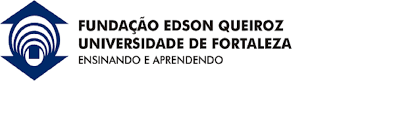

# MINERAÇÃO DE TEXTOS E DA WEB

## ATIVIDADE 03

#### GRUPO 02:
- Nicole Wirtzbiki
- Agenor Júnior
- Torricelli Evangelista

------------------------------------------------------------------------------------------------------------------
INICIO ATIVIDADE 03

- 01. Vetor de features a partir do dataset de treinamento (BOW-Unigramas, BOW-bigramas, sinonimos, hiperonimos, tf-idf, word-embeddings). Obs: nao necessariamente todas as features; Podem ser testadas varias combinacoes de festures.

- 02. Definição do Classificador (Naive Bayes, Logistic Regression, SVM, Random Forest). Obs: devem ser testados vários classificadores.

- 03. Treinamento usando Cross-Validation para as duas sub-tarefas, com apresentacao da Matriz de Confusao e das metricas Precisão, Cobertura, F-Measure, de cada classe.

Dia 17/07/2020 serão enviados às equipe o held-out dataset (a ser definido pelo professor), que será usado como benchmarking de avaliação das equipes.
Obs: podem usar NLTK , SpaCy, Scikit Learn. 

### IMPORTANTO PACOTES NECESSÁRIOS

In [475]:
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re # Importando o módulo "REGEX" para expressões regulares.
from textblob import TextBlob
import pandas as pd
import string
import nltk
#nltk.download('punkt')
#nltk.download('average_perceptron_tagger')
#nltk.download('wordnet')
from nltk.corpus import wordnet as wn

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TweetTokenizer

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV #com cross validation
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from empath import Empath

from sklearn.model_selection import train_test_split,  cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score

from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler

from contextlib import redirect_stdout
import os

----------------------------------------------------------------------
# 1 - CARREGANDO DATASET DE TREINO

In [476]:
#leitura para objeto dataframe
tweets = pd.read_csv('/home/nico/Área de Trabalho/MineracaoDadosWeb/entrega 2/olid-training-v1.0.tsv', sep='\t',encoding= 'utf-8')

#conversão da coluna 'id' de inteiro para string
tweets['id'] = tweets['id'].astype('str')

#visualização dos primeiros registros. tweets de treino para subtask_a
tweets = tweets[['subtask_c','subtask_b','subtask_a','id','tweet']]
tweets

,subtask_c,subtask_b,subtask_a,id,tweet
0,NaN,UNT,OFF,86426,@USER She should ask a few native Americans wh...
1,IND,TIN,OFF,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...
2,NaN,NaN,NOT,16820,Amazon is investigating Chinese employees who ...
3,NaN,UNT,OFF,62688,"@USER Someone should'veTaken"" this piece of sh..."
4,NaN,NaN,NOT,43605,@USER @USER Obama wanted liberals &amp; illega...
...,...,...,...,...,...
13235,IND,TIN,OFF,95338,@USER Sometimes I get strong vibes from people...
13236,NaN,NaN,NOT,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...
13237,OTH,TIN,OFF,82921,@USER And why report this garbage. We don't g...
13238,NaN,UNT,OFF,27429,@USER Pussy


#### CONTANDO AS CLASSIFICAÇÕES DAS SUBTAKS A E B

In [477]:
tweets['subtask_a'].value_counts()

NOT    8840
OFF    4400
Name: subtask_a, dtype: int64

In [478]:
tweets['subtask_b'].value_counts() #só os tweets que são OFF

TIN    3876
UNT     524
Name: subtask_b, dtype: int64

In [479]:
sent_map = {'NOT': 'inofensivo', 'OFF': 'ofensivo'}

----------------------------------------------------------------------
# 2 - CARREGANDO OS DATASETS DE TESTE

## `testset_a`

In [480]:
testset_a = pd.read_csv('/home/nico/Área de Trabalho/MineracaoDadosWeb/entrega 2/testset-levela.tsv', sep='\t',encoding= 'utf-8')
testset_a

,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,27014,"#ConstitutionDay is revered by Conservatives, ..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3,13876,#Watching #Boomer getting the news that she is...
4,60133,#NoPasaran: Unity demo to oppose the far-right...
...,...,...
855,73439,#DespicableDems lie again about rifles. Dem Di...
856,25657,#MeetTheSpeakers 🙌 @USER will present in our e...
857,67018,3 people just unfollowed me for talking about ...
858,50665,#WednesdayWisdom Antifa calls the right fascis...


## `testset_b`

In [481]:
testset_b = pd.read_csv('/home/nico/Área de Trabalho/MineracaoDadosWeb/entrega 2/testset-levelb.tsv', sep='\t',encoding= 'utf-8')
testset_b

,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,60133,#NoPasaran: Unity demo to oppose the far-right...
2,83681,. . . What the fuck did he do this time?
3,65507,@USER Do you get the feeling he is kissing @US...
4,12588,@USER Nigga ware da hits at
...,...,...
235,22569,"#Antifa are mentally unstable cowards, pretend..."
236,48938,@USER @USER And Browning looked like dog shit ...
237,41438,All two of them taste like ass. URL
238,73439,#DespicableDems lie again about rifles. Dem Di...


----------------------------------------------------------------------
# 3 - CRIAÇÃO DE FEATURES DA LINGUAGEM
FEATURES CRIADAS MANUALMENTE COM INFORMAÇÕES RETIRADAS DE CONTAGENS NO CORPUS

#### 3.1 - CONTANDO PALAVRAS

In [482]:
#testset_a
testset_a['word_count'] = testset_a['tweet'].apply(lambda x: len(str(x).split()))
#testset_b
testset_b['word_count'] = testset_b['tweet'].apply(lambda x: len(str(x).split()))

#dataset de treino
tweets['word_count'] = tweets['tweet'].apply(lambda x: len(str(x).split()))
tweets[:3]

,subtask_c,subtask_b,subtask_a,id,tweet,word_count
0,NaN,UNT,OFF,86426,@USER She should ask a few native Americans wh...,14
1,IND,TIN,OFF,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,11
2,NaN,NaN,NOT,16820,Amazon is investigating Chinese employees who ...,27


#### 3.2 - CONTANDO CARACTERES

In [483]:
#testset_a
testset_a['char_counts'] = testset_a['tweet'].apply(lambda x: len(x))
#testset_b
testset_b['char_counts'] = testset_b['tweet'].apply(lambda x: len(x))

#dataset de treino
tweets['char_counts'] = tweets['tweet'].apply(lambda x: len(x))
tweets[:3]

,subtask_c,subtask_b,subtask_a,id,tweet,word_count,char_counts
0,NaN,UNT,OFF,86426,@USER She should ask a few native Americans wh...,14,71
1,IND,TIN,OFF,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,11,67
2,NaN,NaN,NOT,16820,Amazon is investigating Chinese employees who ...,27,182


#### 3.3 - COMPRIMENTO MÉDIO DAS PALAVRAS

In [484]:
def get_avg_word_len(x):
    words = x.split()
    word_len = 0
    for word in words:
        word_len = word_len + len(word)
    return word_len/len(words)

In [485]:
#testset_a
testset_a['avg_word_len'] = testset_a['tweet'].apply(lambda x: get_avg_word_len(x))
#testset_b
testset_b['avg_word_len'] = testset_b['tweet'].apply(lambda x: get_avg_word_len(x))

#dataset de treino
tweets['avg_word_len'] = tweets['tweet'].apply(lambda x: get_avg_word_len(x))
tweets[:3]

,subtask_c,subtask_b,subtask_a,id,tweet,word_count,char_counts,avg_word_len
0,NaN,UNT,OFF,86426,@USER She should ask a few native Americans wh...,14,71,4.142857
1,IND,TIN,OFF,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,11,67,5.181818
2,NaN,NaN,NOT,16820,Amazon is investigating Chinese employees who ...,27,182,5.777778


#### 3.4 - CONTANDO STOPWORDS

In [486]:
#print(STOP_WORDS)

In [487]:
#testset_a
testset_a['stop_words_len'] = testset_a['tweet'].apply(lambda x: len([t for t in x.split() if t in STOP_WORDS]))
#testset_b
testset_b['stop_words_len'] = testset_b['tweet'].apply(lambda x: len([t for t in x.split() if t in STOP_WORDS]))

#dataset de treino
tweets['stop_words_len'] = tweets['tweet'].apply(lambda x: len([t for t in x.split() if t in STOP_WORDS]))
tweets[:3]

,subtask_c,subtask_b,subtask_a,id,tweet,word_count,char_counts,avg_word_len,stop_words_len
0,NaN,UNT,OFF,86426,@USER She should ask a few native Americans wh...,14,71,4.142857,8
1,IND,TIN,OFF,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,11,67,5.181818,0
2,NaN,NaN,NOT,16820,Amazon is investigating Chinese employees who ...,27,182,5.777778,8


#### 3.5 - CONTANDO #HASHTAGS E @MENTIONS

In [488]:
#testset_a
testset_a['hashtags_count'] = testset_a['tweet'].apply(lambda x: len([t for t in x.split() if t.startswith('#')]))
testset_a['mentions_count'] = testset_a['tweet'].apply(lambda x: len([t for t in x.split() if t.startswith('@')]))
#testset_b
testset_b['hashtags_count'] = testset_b['tweet'].apply(lambda x: len([t for t in x.split() if t.startswith('#')]))
testset_b['mentions_count'] = testset_b['tweet'].apply(lambda x: len([t for t in x.split() if t.startswith('@')]))

#dataset de treino
tweets['hashtags_count'] = tweets['tweet'].apply(lambda x: len([t for t in x.split() if t.startswith('#')]))
tweets['mentions_count'] = tweets['tweet'].apply(lambda x: len([t for t in x.split() if t.startswith('@')]))
tweets[:3]

,subtask_c,subtask_b,subtask_a,id,tweet,word_count,char_counts,avg_word_len,stop_words_len,hashtags_count,mentions_count
0,NaN,UNT,OFF,86426,@USER She should ask a few native Americans wh...,14,71,4.142857,8,0,1
1,IND,TIN,OFF,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,11,67,5.181818,0,2,3
2,NaN,NaN,NOT,16820,Amazon is investigating Chinese employees who ...,27,182,5.777778,8,5,0


#### 3.6 - CONTAGEM DE DIGITOS NUMÉRICOS NOS TWEETS

In [489]:
#testset_a
testset_a['numerics_count'] = testset_a['tweet'].apply(lambda x: len([t for t in x.split() if t.isdigit()]))
#testset_b
testset_b['numerics_count'] = testset_b['tweet'].apply(lambda x: len([t for t in x.split() if t.isdigit()]))

#dataset de treino
tweets['numerics_count'] = tweets['tweet'].apply(lambda x: len([t for t in x.split() if t.isdigit()]))
tweets[tweets['numerics_count']>0][:3]

,subtask_c,subtask_b,subtask_a,id,tweet,word_count,char_counts,avg_word_len,stop_words_len,hashtags_count,mentions_count,numerics_count
11,NaN,NaN,NOT,42992,@USER What’s the difference between #Kavanaugh...,40,279,5.825000,13,9,2,1
54,GRP,TIN,OFF,84102,4 out of 10 British people are basically full-...,20,124,5.250000,7,0,0,4
59,OTH,TIN,OFF,33853,@USER @USER The prison system is so fucked. W...,39,222,4.692308,17,0,2,1


#### 3.7 - CONTAGEM DE PALAVRAS EM CAIXA ALTA

In [490]:
#testset_a
testset_a['capital_count'] = testset_a['tweet'].apply(lambda x: len([t for t in x.split() if t.isupper() and t != '@USER']))
#testset_b
testset_b['capital_count'] = testset_b['tweet'].apply(lambda x: len([t for t in x.split() if t.isupper() and t != '@USER']))

#dataset de treino
tweets['capital_count'] = tweets['tweet'].apply(lambda x: len([t for t in x.split() if t.isupper() and t != '@USER']))
tweets[tweets['capital_count']>0][:3]

,subtask_c,subtask_b,subtask_a,id,tweet,word_count,char_counts,avg_word_len,stop_words_len,hashtags_count,mentions_count,numerics_count,capital_count
1,IND,TIN,OFF,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,11,67,5.181818,0,2,3,0,2
2,NaN,NaN,NOT,16820,Amazon is investigating Chinese employees who ...,27,182,5.777778,8,5,0,0,5
9,IND,TIN,OFF,13384,@USER Canada doesn’t need another CUCK! We alr...,19,138,6.315789,6,4,1,0,1


----------------------------------------------------------------------
# 4 - NORMALIZAÇÃO DOS TWEETS

PREPROCESSAMENTO E LIMPEZA DOS DADOS

#### 4.1 - TRANSFORMANDO EM CAIXA BAIXA

In [491]:
#testset_a
testset_a['tweet'] = testset_a['tweet'].apply(lambda x: x.lower())
#testset_b
testset_b['tweet'] = testset_b['tweet'].apply(lambda x: x.lower())

#dataset de treino
tweets['tweet'] = tweets['tweet'].apply(lambda x: x.lower())

#### 4.2 - REMOVER PONTUAÇÃO E CARACTERES ESPECIAIS

In [492]:
#testset_a
testset_a['tweet'] = testset_a['tweet'].apply(lambda x: re.sub('[^A-Z a-z 0-9-]+', '', x))
#testset_b
testset_b['tweet'] = testset_b['tweet'].apply(lambda x: re.sub('[^A-Z a-z 0-9-]+', '', x))

#dataset de treino
tweets['tweet'] = tweets['tweet'].apply(lambda x: re.sub('[^A-Z a-z 0-9-]+', '', x))

#### 4.3 - REMOVER REPETIÇÕES DE "@user"

In [493]:
#testset_a
testset_a['tweet'] = testset_a['tweet'].apply(lambda x: re.sub('(user |user| user )+',' user ', x))
#testset_b
testset_b['tweet'] = testset_b['tweet'].apply(lambda x: re.sub('(user |user| user )+',' user ', x))

#dataset de treino
tweets['tweet'] = tweets['tweet'].apply(lambda x: re.sub('(user |user| user )+',' user ', x))

#### 4.4 - REMOVER ESPAÇOS MÚLTIPLOS

In [494]:
#testset_a
testset_a['tweet'] = testset_a['tweet'].apply(lambda x: " ".join(x.split()))
#testset_b
testset_b['tweet'] = testset_b['tweet'].apply(lambda x: " ".join(x.split()))

#dataset de treino
tweets['tweet'] = tweets['tweet'].apply(lambda x: " ".join(x.split()))

#### 4.5 - CORREÇÕES DE VOCABULÁRIO

In [495]:
def treat_text(text):
    text = re.sub('url$', '', text, flags=re.MULTILINE) #remover url
    text = re.sub(r'^n$', 'and', text, flags=re.MULTILINE) #correção de vocabulário
    text = re.sub(r'^u$', 'you', text, flags=re.MULTILINE) #correção de vocabulário
    text = re.sub(r'^r$', 'are', text, flags=re.MULTILINE) #correção de vocabulário
    text = re.sub(r'^sh*t$', 'shit', text, flags=re.MULTILINE) #correção de vocabulário
    return text

In [496]:
#testset_a
testset_a['tweet'] = testset_a['tweet'].apply(lambda x: treat_text(x))
#testset_b
testset_b['tweet'] = testset_b['tweet'].apply(lambda x: treat_text(x))

#dataset de treino
tweets['tweet'] = tweets['tweet'].apply(lambda x: treat_text(x))

#### 4.6 - EXPANDIR PALAVRAS CONTRAÍDAS

In [497]:
contractions = {
    "whats": "what is",
    "what's": "what is",
    "what'd": "what would",
    "where's": "where is",
    "who's": "who is",
    "dont": "do not",
    "doesnt": "does not",
    "its": "it is",
    "youre": "you are",
    "you're": "you are",
    "you'll": "you will",
    "you'd": "you would",
    "you've": "you have",
    "youve": "you have",
    "you'd've": "you would have",
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "hes": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "im": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "shes": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "wanna": "want to",
    "gonna": "going to",
    "gotta": "have got to",
    " u ": " you ",
    " ur ": " your ",
    " n ": " and "}

In [498]:
def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x

In [499]:
#testset_a
testset_a['tweet'] = testset_a['tweet'].apply(lambda x: cont_to_exp(x))
#testset_b
testset_b['tweet'] = testset_b['tweet'].apply(lambda x: cont_to_exp(x))

#dataset de treino
tweets['tweet'] = tweets['tweet'].apply(lambda x: cont_to_exp(x))
tweets['tweet'].head()

0    user she should ask a few native americans wha...
1      user go home you are drunk user maga trump2020 
2    amazon is investigating chinese employees who ...
3    user someone shouldvetaken this piece of shit ...
4    user obama wanted liberals amp illegals to mov...
Name: tweet, dtype: object

#### 4.7 - REMOVER STOPWORDS

In [500]:
#testset_a
testset_a['tweet'] = testset_a['tweet'].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))
#testset_b
testset_b['tweet'] = testset_b['tweet'].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))

#dataset de treino
tweets['tweet'] = tweets['tweet'].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))

In [501]:
tweets['tweet'][:5]

0                            user ask native americans
1                  user home drunk user maga trump2020
2    amazon investigating chinese employees selling...
3                user shouldvetaken piece shit volcano
4    user obama wanted liberals amp illegals red st...
Name: tweet, dtype: object

#### 4.8 - POS TAGGER

In [502]:
nlp = spacy.load('en_core_web_sm')

In [503]:
def pos_tag(x):
    x_list = []
    doc = nlp(x)
    for token in doc: 
        pos = (token, token.pos_) 
        x_list.append(pos)
    return x_list
    
# You want list of Verb tokens 
#print("Verbs:", [token.text for token in doc if token.pos_ == "VERB"]) 

In [504]:
#testset_a
#testset_a['pos_tag'] = testset_a['tweet'].apply(lambda x: pos_tag(x))
#testset_b
#testset_b['pos_tag'] = testset_b['tweet'].apply(lambda x: pos_tag(x))

#dataset de treino
#tweets['pos_tag'] = tweets['tweet'].apply(lambda x: pos_tag(x))

In [505]:
#tweets['pos_tag'].head()

#### 4.9 - LEMMAS

In [506]:
def make_to_base(x):
    x_list = []
    doc = nlp(x)
    
    for token in doc:
        lemma = str(token.lemma_)
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text
        x_list.append(lemma)
    return(" ".join(x_list))

In [507]:
#testset_a
testset_a['tweet'] = testset_a['tweet'].apply(lambda x: make_to_base(x))
#testset_b
testset_b['tweet'] = testset_b['tweet'].apply(lambda x: make_to_base(x))

#dataset de treino
tweets['tweet'] = tweets['tweet'].apply(lambda x: make_to_base(x))

In [508]:
tweets['tweet']

0                                user ask native americans
1                      user home drunk user maga trump2020
2        amazon investigate chinese employee sell inter...
3                    user shouldvetaken piece shit volcano
4            user obama want liberal amp illegal red state
                               ...                        
13235    user someti ame strong vibes people mans vibe ...
13236              benidorm creamfields maga shabby summer
13237                             user report garbage crap
13238                                           user pussy
13239    spanishrevenge vs justice humanrights freedomo...
Name: tweet, Length: 13240, dtype: object

#### 4.10 - REMOÇÃO DE PALAVRAS COMUNS 

`Separando as 10 palavras mais comuns em todos os tweets`

In [509]:
def get_common_words(x):
    text = ' '.join(x)
    text = text.split()
    freq_comm = pd.Series(text).value_counts()
    f10 = freq_comm[:10]
    return f10

#testset_a
testset_a_f10 = get_common_words(testset_a['tweet'])
#testset_b
testset_b_f10 = get_common_words(testset_b['tweet'])

#dataset de treino
tweets_f10 = get_common_words(tweets['tweet'])
tweets_f10

user            13244
liberal          1549
gun              1525
not              1253
control          1235
antifa           1167
like             1148
-                1083
maga             1006
conservative     1004
dtype: int64

`Retirando as 10 palavras mais comuns`

In [510]:
#testset_a
testset_a['tweet'] = testset_a['tweet'].apply(lambda x: " ".join(t for t in x.split() if t not in testset_a_f10))
#testset_b
testset_b['tweet'] = testset_b['tweet'].apply(lambda x: " ".join(t for t in x.split() if t not in testset_b_f10))

#dataset de treino
tweets['tweet'] = tweets['tweet'].apply(lambda x: " ".join(t for t in x.split() if t not in tweets_f10))

#### 4.11 - REMOÇÃO DE PALAVRAS RARAS

`Separando as palavras raras em todos os tweets`

In [511]:
def get_rare_words(x):
    text = ' '.join(x)
    text = text.split()
    freq_comm = pd.Series(text).value_counts()
    rare_words = freq_comm[freq_comm.values == 1]
    return rare_words

In [512]:
#testset_a
testset_a_rare = get_rare_words(testset_a['tweet'])
#testset_b
testset_b_rare = get_rare_words(testset_b['tweet'])

#dataset de treino
tweets_rare = get_rare_words(tweets['tweet'])
tweets_rare

dgps2018                1
intellect               1
ripoff                  1
lmfaoooooo              1
doingsnon               1
                       ..
andnevervotedemocrat    1
governing               1
zeland                  1
brilliancy              1
idiotalert              1
Length: 10201, dtype: int64

`Retirando as palavras raras`

In [514]:
#testset_a
testset_a['tweet'] = testset_a['tweet'].apply(lambda x: ' '.join([t for t in x.split() if t not in testset_a_rare]))
#testset_b
testset_b['tweet'] = testset_b['tweet'].apply(lambda x: ' '.join([t for t in x.split() if t not in testset_b_rare]))

#dataset de treino
tweets['tweet'] = tweets['tweet'].apply(lambda x: ' '.join([t for t in x.split() if t not in tweets_rare]))

------------------------------------------------------------------------------------------------------------------
# 5 - FEATURES

#### 5.1 - FEATURES DA LINGUAGEM

In [515]:
tweets.shape

(13240, 13)

In [516]:
testset_a.shape

(860, 10)

In [517]:
testset_b.shape

(240, 10)

In [518]:
#testset_a
manual_features_a = testset_a.drop(labels=['id','tweet'], axis = 1).reset_index(drop=True)
#testset_b
manual_features_b = testset_b.drop(labels=['id','tweet'], axis = 1).reset_index(drop=True)

#dataset de treino a
manual_features = tweets.drop(labels=['subtask_a','subtask_b','subtask_c','id','tweet'], axis = 1).reset_index(drop=True)
manual_features

,word_count,char_counts,avg_word_len,stop_words_len,hashtags_count,mentions_count,numerics_count,capital_count
0,14,71,4.142857,8,0,1,0,0
1,11,67,5.181818,0,2,3,0,2
2,27,182,5.777778,8,5,0,0,5
3,11,65,5.000000,4,0,1,0,0
4,12,72,5.083333,3,0,2,0,0
...,...,...,...,...,...,...,...,...
13235,25,129,4.200000,11,0,1,0,2
13236,12,62,3.916667,3,0,0,0,0
13237,11,57,4.181818,4,0,1,0,0
13238,2,11,5.000000,0,0,1,0,0


In [519]:
#dataset de treino subtask_b
tweets_b = tweets.dropna(subset=['subtask_b'])
manual_features_tb = tweets_b.drop(labels=['subtask_a','subtask_b','subtask_c','id','tweet'], axis = 1).reset_index(drop=True)
manual_features_tb.head()

,word_count,char_counts,avg_word_len,stop_words_len,hashtags_count,mentions_count,numerics_count,capital_count
0,14,71,4.142857,8,0,1,0,0
1,11,67,5.181818,0,2,3,0,2
2,11,65,5.000000,4,0,1,0,0
3,6,33,4.666667,2,0,1,0,0
4,6,32,4.500000,0,0,2,0,0


#### 5.2 - BOW UNIGRAMA DE VETORES DE FREQUÊNCIA

In [520]:
cvz = CountVectorizer()

In [521]:
VOCABULARIO_TWEETS = cvz.fit(pd.concat([testset_a['tweet'],
                                        testset_b['tweet'],
                                        tweets['tweet']])).vocabulary_

In [522]:
#testset_a
text_counts_a = cvz.transform(testset_a['tweet']) #guarda BOW em text_counts
dfr_bow_a = pd.DataFrame(text_counts_a.toarray(), columns=cvz.get_feature_names())
#testset_b
text_counts_b = cvz.transform(testset_b['tweet']) #guarda BOW em text_counts
dfr_bow_b = pd.DataFrame(text_counts_b.toarray(), columns=cvz.get_feature_names())
dfr_bow_b.head()

,005,06,08,09,090818,10,100,1000,100000,100s,...,zealand,zealot,zeetvserials,zero,zi,zionist,zombie,zone,zones,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [523]:
#dataset de treino subtask_a
text_counts = cvz.transform(tweets['tweet']) #guarda BOW em text_counts
dfr_bow = pd.DataFrame(text_counts.toarray(), columns=cvz.get_feature_names())
dfr_bow.head()

,005,06,08,09,090818,10,100,1000,100000,100s,...,zealand,zealot,zeetvserials,zero,zi,zionist,zombie,zone,zones,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [524]:
#dataset de treino subtask_b
text_counts_tb = cvz.transform(tweets_b['tweet']) #guarda BOW em text_counts_tb
dfr_bow_tb = pd.DataFrame(text_counts_tb.toarray(), columns=cvz.get_feature_names())
dfr_bow_tb.head()

,005,06,08,09,090818,10,100,1000,100000,100s,...,zealand,zealot,zeetvserials,zero,zi,zionist,zombie,zone,zones,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 5.3 - BOW BIGRAMA DE VETORES DE FREQUÊNCIA
* HOUVE ERRO POR FALTA DE MEMÓRIA AO ALOCAR OS DATASETS DE TREINO, POR ISSO NÃO FOI UTILIZADO

In [400]:
cv2 = CountVectorizer(ngram_range=(2,2))

In [401]:
VOCABULARIO_TWEETS = cv2.fit(pd.concat([testset_a['tweet'],
                                        testset_b['tweet'],
                                        tweets['tweet']])).vocabulary_

In [402]:
#testset_a
text_counts_a = cv2.transform(testset_a['tweet']) #guarda BOW em text_counts
dfr_bow2_a = pd.DataFrame(text_counts_a.toarray(), columns=cv2.get_feature_names())
#testset_b
text_counts_b = cv2.transform(testset_b['tweet']) #guarda BOW em text_counts
dfr_bow2_b = pd.DataFrame(text_counts_b.toarray(), columns=cv2.get_feature_names())
dfr_bow2_b.head()

,005 ego,005 moment,06 kg,06 star,08 12,08 suppose,09 14,09 open,090818 2nd,090818 story,...,zone law,zone people,zone rational,zone ridiculous,zone shoot,zone tds,zone work,zones cities,zones cri,zuckerberg soros
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [403]:
#dataset de treino subtask_a
#text_counts = cv2.transform(tweets['tweet']) #guarda BOW em text_counts
#dfr_bow2 = pd.DataFrame(text_counts.toarray(), columns=cv2.get_feature_names())

#dataset de treino subtask_b
#text_counts_2b = cv2.transform(tweets_b['tweet']) #guarda BOW em text_counts2
#dfr_bow_2b = pd.DataFrame(text_counts.toarray(), columns=cv2.get_feature_names())

#### 5.4 - VETORIZAÇÃO TD-IDF

In [404]:
tfidf = TfidfVectorizer()

In [405]:
vocab_tweets = tfidf.fit(pd.concat([testset_a['tweet'],
                                        testset_b['tweet'],
                                        tweets['tweet']])).vocabulary_

In [406]:
#testset_a
tfidf_a = tfidf.transform(testset_a['tweet'])
#testset_b
tfidf_b = tfidf.transform(testset_b['tweet'])

#dataset de treino subtask_a
tfidf_tweets = tfidf.transform(tweets['tweet'])
tfidf_tweets

<13240x7512 sparse matrix of type '<class 'numpy.float64'>'
	with 101335 stored elements in Compressed Sparse Row format>

In [407]:
#dataset de treino subtask_b
tfidf_tweets_tb = tfidf.transform(tweets_b['tweet'])
tfidf_tweets_tb

<4400x7512 sparse matrix of type '<class 'numpy.float64'>'
	with 37547 stored elements in Compressed Sparse Row format>

In [408]:
tfidf_b

<240x7512 sparse matrix of type '<class 'numpy.float64'>'
	with 1331 stored elements in Compressed Sparse Row format>

#### 5.5 - WORD EMBEDDINGS: VETORES GLOVE COM SPACY

In [409]:
nlp = spacy.load('en_core_web_lg')

In [410]:
def get_vec(x):
    doc = nlp(x)
    return doc.vector.reshape(1, -1)

In [444]:
%%time
#testset_a
testset_a['vec'] = testset_a['tweet'].apply(lambda x: get_vec(x))
#testset_b
testset_b['vec'] = testset_b['tweet'].apply(lambda x: get_vec(x))

#dataset de treino subtask_a
tweets['vec'] = tweets['tweet'].apply(lambda x: get_vec(x))
tweets['vec']

CPU times: user 2min 2s, sys: 97.4 ms, total: 2min 2s
Wall time: 2min 3s


0        [[-0.22207999, -0.011213002, -0.42468032, -0.0...
1        [[-0.15683, 0.11466, -0.21521668, -0.034432665...
2        [[-0.19677131, 0.16656922, -0.007898822, 0.063...
3        [[-0.48832, -0.069639996, -0.05943, 0.125265, ...
4        [[-0.10551766, 0.13025834, 0.1919475, 0.029003...
                               ...                        
13235    [[-0.1268047, 0.1118146, -0.0778862, -0.083835...
13236    [[0.39715502, 0.166096, 0.17001, 0.013473999, ...
13237    [[-0.69181997, -0.13534333, -0.06272934, -0.08...
13238    [[-0.67881, -0.75509, -0.25609, 0.044741, 0.25...
13239    [[-0.211325, 0.017242752, 0.07692652, 0.034257...
Name: vec, Length: 13240, dtype: object

In [445]:
#dataset de treino subtask_b
tweets_b['vec'] = tweets_b['tweet'].apply(lambda x: get_vec(x))
tweets_b['vec']

<ipython-input-445-a0f6127aed3b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_b['vec'] = tweets_b['tweet'].apply(lambda x: get_vec(x))


0        [[-0.22207999, -0.011213002, -0.42468032, -0.0...
1        [[-0.15683, 0.11466, -0.21521668, -0.034432665...
3        [[-0.48832, -0.069639996, -0.05943, 0.125265, ...
5        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
6        [[-0.405465, 0.09807774, -0.39310747, -0.13841...
                               ...                        
13223    [[-0.42084712, -0.053085677, -0.08722335, -0.0...
13227    [[-0.3316825, -0.3737634, -0.26345024, 0.00013...
13235    [[-0.1268047, 0.1118146, -0.0778862, -0.083835...
13237    [[-0.69181997, -0.13534333, -0.06272934, -0.08...
13238    [[-0.67881, -0.75509, -0.25609, 0.044741, 0.25...
Name: vec, Length: 4400, dtype: object

#### 5.6 - EMPATH

In [319]:
lexicon = Empath() 

In [414]:
#testset_a
emp_testa = testset_a['tweet'].apply(lexicon.analyze).apply(pd.Series)
#testset_b
emp_testb = testset_b['tweet'].apply(lexicon.analyze).apply(pd.Series)

In [416]:
#dataset de treino subtask_a
emp_ta = tweets['tweet'].apply(lexicon.analyze).apply(pd.Series)
#dataset de treino subtask_b
emp_tb = tweets_b['tweet'].apply(lexicon.analyze).apply(pd.Series)
emp_tb

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,2.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


----------------------------------------------------------------------
# 6 - MODELOS DE MACHINE LEARNING PARA CLASSIFICAÇÃO DOS TEXTOS

#### 5.1 - DEFININDO OS ALGORITMOS DE MACHINE LEARNING

In [102]:
gnb = GaussianNB()
lgr = LogisticRegression(random_state=42, max_iter=200)
svm = LinearSVC(random_state=42, max_iter=200)
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=200)
#sgd = SGDClassifier(n_jobs=-1, random_state=42, max_iter=200)
#lgrcv = LogisticRegressionCV(cv = 2, random_state=42, max_iter=1000)
#knn = KNeighborsClassifier(n_neighbors=5)
#ada = AdaBoostClassifier()

In [103]:
#clf = {'GNB': gnb, 'SGD': sgd, 'LGR': lgr, 'LGR-CV': lgrcv, 'SVM': svm, 'RFC': rfc, 'KNN': knn, 'ADA': ada}

In [104]:
clf = {'GNB': gnb, 'LGR': lgr, 'SVM': svm, 'RFC': rfc}
clf.keys()

dict_keys(['GNB', 'LGR', 'SVM', 'RFC'])

#### 5.2 - FUNÇÃO DE CLASSIFICAÇÃO

In [105]:
def classify(X,y):
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
    
    for key in clf.keys():
        clf[key].fit(X_train, y_train)
        y_pred = clf[key].predict(X_test)
        #ac = accuracy_score(y_test, y_pred)
        ac = cross_val_score(clf[key], X, y, cv=5)
        f1 = f1_score(y_test, y_pred, average='macro')
        print(key, " ---> ", 'precisão:', np.mean(ac), 'f1 score:', f1)

----------------------------------------------------------------------
# 7 - SUBTASK A

#### 7.1 - DEFININDO O TARGET

In [551]:
binarizador_label = LabelBinarizer()
t = tweets['subtask_a']

y = binarizador_label.fit_transform(t)

#### 7.2 MODELO COM BOW DE FREQUÊNCIA UNIGRAMA

In [314]:
%%time
classify(dfr_bow, y)

/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GNB  --->  precisão: 0.4641238670694864 f1 score: 0.46400760129653407


/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGR  --->  precisão: 0.7571752265861027 f1 score: 0.696369210862462


/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
<ipython-input-105-89430fe00da1>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf[key].fit(X_train, y_train)


SVM  --->  precisão: 0.7356495468277946 f1 score: 0.6938940651515502
RFC  --->  precisão: 0.770392749244713 f1 score: 0.7265793342191571
CPU times: user 11min 49s, sys: 21.2 s, total: 12min 10s
Wall time: 3min 37s


RANDOM FOREST

In [108]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(dfr_bow)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [555]:
%time
model1 = RandomForestClassifier()
model1.fit(X_train, y_train)
#score_basic1 = model1.score(X_test, y_test)
score_basic1 = cross_val_score(model1,dfr_bow,y,cv=5)
score_cross1 = np.mean(score_basic1) #score melhorado pela cross validation


#score_basic1
score_cross1

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


<ipython-input-555-26e0cc489d5d>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model1.fit(X_train, y_train)
/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y w

0.7574773413897281

In [553]:
#Matriz de Confusão para Random Forest
pred1 = model1.predict(X_test)
print(confusion_matrix(y_test, pred1)) #labels=["OFF","NOT"]
print(classification_report(y_test, pred1))

[[773   2]
 [102   3]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       775
           1       0.60      0.03      0.05       105

    accuracy                           0.88       880
   macro avg       0.74      0.51      0.50       880
weighted avg       0.85      0.88      0.83       880



0 = NOT | 1 = OFF

#### 7.3 -  MODELO COM FEATURES DA LINGUAGEM

In [112]:
%%time
classify(manual_features, y)

GNB  --->  precisão: 0.5060422960725075 f1 score: 0.5038001667569216
LGR  --->  precisão: 0.6669184290030211 f1 score: 0.40117655263514146
SVM  --->  precisão: 0.6680513595166163 f1 score: 0.40907488013770366
RFC  --->  precisão: 0.629154078549849 f1 score: 0.5210585448691738
CPU times: user 5.01 s, sys: 193 ms, total: 5.2 s
Wall time: 1.86 s


SUPPORT VECTOR MACHINE - SVM

In [562]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(manual_features)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [563]:
model2 = SVC(kernel='linear')
model2.fit(X_train, y_train)
score_basic2 = model2.score(X_test, y_test)
#score_basic2 = cross_val_score(model2, X, y, cv=5)
#score_cross2 = np.mean(score_basic2) #score melhorado pela cross validation


score_basic2
#score_cross2

/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6676737160120846

In [564]:
#Matriz de Confusão para SVM
pred2 = model2.predict(X_test)
print(confusion_matrix(y_test, pred2)) #labels=["OFF","NOT"]
print(classification_report(y_test, pred2))

[[1768    0]
 [ 880    0]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      1768
           1       0.00      0.00      0.00       880

    accuracy                           0.67      2648
   macro avg       0.33      0.50      0.40      2648
weighted avg       0.45      0.67      0.53      2648



/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0 = NOT | 1 = OFF

#### 7.4 - MODELO COM BOW FREQUÊNCIA & FEATURES DA LINGUAGEM

In [262]:
X = dfr_bow.join(manual_features)

In [118]:
%%time
classify(X,y)

GNB  --->  precisão: 0.4641238670694864 f1 score: 0.46400760129653407
LGR  --->  precisão: 0.7552870090634441 f1 score: 0.6949080939223572


/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


SVM  --->  precisão: 0.7356495468277946 f1 score: 0.6942882570142506
RFC  --->  precisão: 0.7688821752265861 f1 score: 0.6918429003021147
CPU times: user 5min 21s, sys: 2.41 s, total: 5min 24s
Wall time: 1min 30s


RANDOM FOREST

In [263]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [264]:
model3 = RandomForestClassifier()
model3.fit(X_train, y_train)
#score_basic3 = model3.score(X_test, y_test)
score_basic3 = cross_val_score(model3, X, y, cv=5)
score_cross3 = np.mean(score_basic3) #score melhorado pela cross validation


#score_basic3
score_cross3

0.770392749244713

In [265]:
#Matriz de Confusão para Random Forest
pred3 = model3.predict(X_test)
print(confusion_matrix(y_test, pred3)) #labels=["OFF","NOT"]
print(classification_report(y_test, pred3))

[[1685   83]
 [ 525  355]]
              precision    recall  f1-score   support

         NOT       0.76      0.95      0.85      1768
         OFF       0.81      0.40      0.54       880

    accuracy                           0.77      2648
   macro avg       0.79      0.68      0.69      2648
weighted avg       0.78      0.77      0.74      2648



0 = NOT | 1 = OFF

#### 7.5 -  MODELO COM TF-IDF

In [122]:
%%time
classify(pd.DataFrame(tfidf_tweets.toarray()),y)

GNB  --->  precisão: 0.4746978851963746 f1 score: 0.47468102860955275
LGR  --->  precisão: 0.7556646525679759 f1 score: 0.6834150732148008
SVM  --->  precisão: 0.7307401812688822 f1 score: 0.6885106262226173
RFC  --->  precisão: 0.773036253776435 f1 score: 0.713513547570636
CPU times: user 14min 2s, sys: 2.82 s, total: 14min 5s
Wall time: 3min 39s


RANDOM FOREST

In [532]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(tfidf_tweets.toarray())
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [533]:
model4 = RandomForestClassifier()
model4.fit(X_train, y_train)
#score_basic4 = model4.score(X_test, y_test)
score_basic4 = cross_val_score(model4, X, y,cv=5)
score_cross4 = np.mean(score_basic4) #score melhorado pela cross validation


#score_basic4
score_cross4

<ipython-input-533-d5e0bc40872b>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model4.fit(X_train, y_train)


0.7722809667673716

In [534]:
#Matriz de Confusão para Random Forest
pred4 = model4.predict(X_test)
print(confusion_matrix(y_test, pred4)) #labels=["OFF","NOT"]
print(classification_report(y_test, pred4))

[[1627  141]
 [ 462  418]]
              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1768
           1       0.75      0.47      0.58       880

    accuracy                           0.77      2648
   macro avg       0.76      0.70      0.71      2648
weighted avg       0.77      0.77      0.76      2648



0 = NOT | 1 = OFF

#### 7.6 - MODELO COM GLOVE

In [268]:
W = np.concatenate(tweets['vec'].to_numpy(), axis=0)

In [269]:
W.shape

(13240, 300)

In [144]:
%%time
classify(pd.DataFrame(W), y)

GNB  --->  precisão: 0.6219788519637462 f1 score: 0.6183842018009302


/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LGR  --->  precisão: 0.7424471299093656 f1 score: 0.6707024970606512


/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


SVM  --->  precisão: 0.7186555891238671 f1 score: 0.5920913578393637
RFC  --->  precisão: 0.7488670694864048 f1 score: 0.662246387972433
CPU times: user 40 s, sys: 901 ms, total: 40.9 s
Wall time: 12.2 s


RANDOM FOREST

In [270]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(W)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [271]:
model5 = RandomForestClassifier()
model5.fit(X_train, y_train)
#score_basic5 = model5.score(X_test, y_test)
score_basic5 = cross_val_score(model5,X,y,cv=5)
score_cross5 = np.mean(score_basic5) #score melhorado pela cross validation


#score_basic5
score_cross5

0.7382930513595166

In [272]:
#Matriz de Confusão para Random Forest
pred5 = model5.predict(X_test)
print(confusion_matrix(y_test, pred5)) #labels=["OFF","NOT"]
print(classification_report(y_test, pred5))

[[1656  112]
 [ 581  299]]
              precision    recall  f1-score   support

         NOT       0.74      0.94      0.83      1768
         OFF       0.73      0.34      0.46       880

    accuracy                           0.74      2648
   macro avg       0.73      0.64      0.65      2648
weighted avg       0.74      0.74      0.71      2648



0 = NOT | 1 = OFF

#### 7.7 - MODELO COM GLOVE & EMPATH

In [420]:
E = np.concatenate(tweets['vec'].to_numpy(), axis=0)

In [421]:
X = (pd.DataFrame(E)).join(emp_ta)

In [422]:
%%time
classify(X, y)

/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GNB  --->  precisão: 0.7080815709969789 f1 score: 0.6826949653405112


/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGR  --->  precisão: 0.7579305135951662 f1 score: 0.7000764224065195


/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
<ipython-input-105-89430fe00da1>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf[key].fit(X_train, y_train)


SVM  --->  precisão: 0.7530211480362538 f1 score: 0.6783284742468416
RFC  --->  precisão: 0.7466012084592145 f1 score: 0.654165652116114
CPU times: user 39.8 s, sys: 364 ms, total: 40.1 s
Wall time: 11.9 s


LOGISTIC REGRESSION

In [423]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [426]:
model6 = LogisticRegression(random_state=42, max_iter=200)
model6.fit(X_train, y_train)
#score_basic6 = model6.score(X_test, y_test)
score_basic6 = cross_val_score(model6, X, y, cv=5)
score_cross6 = np.mean(score_basic6) #score melhorado pela cross validation


#score_basic6
score_cross6

/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7579305135951662

In [427]:
#Matriz de Confusão para Logistic Regression
pred6 = model6.predict(X_test)
print(confusion_matrix(y_test, pred6)) #labels=["OFF","NOT"]
print(classification_report(y_test,pred6))

[[1585  183]
 [ 458  422]]
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      1768
           1       0.70      0.48      0.57       880

    accuracy                           0.76      2648
   macro avg       0.74      0.69      0.70      2648
weighted avg       0.75      0.76      0.74      2648



0 = TIM | 1 = UNT

### 7.8 - MELHOR RESULTADO PARA O SUBTASK A

`TF-IDF` com `RANDOM FOREST`

0 = NOT | 1 = OFF

In [535]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(tfidf_a.toarray())

testset_a_pred = model4.predict(X)   
testset_a_pred = pd.DataFrame(testset_a_pred, columns = ['Label'])
testset_a_pred = pd.concat([testset_a_pred, testset_a['tweet']],axis=1,sort=False)
testset_a_pred

,Label,tweet
0,1,democrats support musli isis child traffic fun...
1,0,constitutionday hate want change
2,0,foxnews nra maga potus trump veteran iswamp dnc
3,0,watch get news make smile
4,0,unity demo far right london
...,...,...
855,0,lie dem law push kavanaugh
856,0,present event 2018 global ampact senior group ...
857,1,3 people talk sorry y all ass wait i have run ...
858,1,wednesdaywisdom call right fascist reality lea...


------------------------------------------------------------------------------------------------------------------
# 8 - SUBTASK B

#### 8.1 - DEFININDO O TARGET

In [536]:
#y = tweets_b['subtask_b']

In [544]:
binarizador_label = LabelBinarizer()
t = tweets_b['subtask_b']

y = binarizador_label.fit_transform(t)

#### 8.2 MODELO COM BOW DE FREQUÊNCIA UNIGRAM

In [312]:
%%time
classify(dfr_bow_tb, y)

/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GNB  --->  precisão: 0.7420454545454546 f1 score: 0.5427148217077687


/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGR  --->  precisão: 0.8784090909090909 f1 score: 0.4855741126208076


/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVM  --->  precisão: 0.8318181818181818 f1 score: 0.5231679456388026


<ipython-input-105-89430fe00da1>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf[key].fit(X_train, y_train)


RFC  --->  precisão: 0.865909090909091 f1 score: 0.5298464213271515
CPU times: user 1min 44s, sys: 634 ms, total: 1min 45s
Wall time: 28.3 s


LOGISTIC REGRESSION

In [429]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(dfr_bow_tb)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [430]:
model7 = LogisticRegression(random_state=42, max_iter=200)
model7.fit(X_train, y_train)
#score_basic7 = model7.score(X_test, y_test)
score_basic7 = cross_val_score(model7, X, y,cv=5)
score_cross7 = np.mean(score_basic7) #score melhorado pela cross validation


#score_basic7
score_cross7

/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.8784090909090909

In [431]:
#Matriz de Confusão para Logistic Regression
pred7 = model7.predict(X_test)
print(confusion_matrix(y_test, pred7)) #labels=["OFF","NOT"]
print(classification_report(y_test,pred7))

[[771   4]
 [103   2]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.94       775
           1       0.33      0.02      0.04       105

    accuracy                           0.88       880
   macro avg       0.61      0.51      0.49       880
weighted avg       0.82      0.88      0.83       880



0 = TIM | 1 = UNT

#### 8.3 - MODELO COM FEATURES DA LINGUAGEM

In [236]:
%%time
classify(manual_features_tb, y)

GNB  --->  precisão: 0.8511363636363637 f1 score: 0.5014509300223586
LGR  --->  precisão: 0.8806818181818182 f1 score: 0.46827794561933533
SVM  --->  precisão: 0.8806818181818182 f1 score: 0.46827794561933533
RFC  --->  precisão: 0.8704545454545455 f1 score: 0.5395715151181363
CPU times: user 2.1 s, sys: 169 ms, total: 2.26 s
Wall time: 1.13 s


LOGISTIC REGRESSION

In [432]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(manual_features_tb)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [433]:
model8 = LogisticRegression(random_state=42, max_iter=200)
model8.fit(X_train, y_train)
#score_basic8 = model8.score(X_test, y_test)
score_basic8 = cross_val_score(model8, X, y,cv=5)
score_cross8 = np.mean(score_basic8) #score melhorado pela cross validation


#score_basic8
score_cross8

/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.8806818181818182

In [434]:
#Matriz de Confusão para Logistic Regression
pred8 = model8.predict(X_test)
print(confusion_matrix(y_test, pred8)) #labels=["OFF","NOT"]
print(classification_report(y_test,pred8))

[[775   0]
 [105   0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       775
           1       0.00      0.00      0.00       105

    accuracy                           0.88       880
   macro avg       0.44      0.50      0.47       880
weighted avg       0.78      0.88      0.82       880



/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0 = TIM | 1 = UNT

#### 8.4 - MODELO COM  BOW DE FREQUÊNCIA & FEATURES DA LINGUAGEM

In [545]:
X = dfr_bow_tb.join(manual_features_tb)

In [242]:
%%time
classify(X,y)

GNB  --->  precisão: 0.7420454545454546 f1 score: 0.5427148217077687
LGR  --->  precisão: 0.8795454545454545 f1 score: 0.4771769348040535
SVM  --->  precisão: 0.8318181818181818 f1 score: 0.5181650018497965
RFC  --->  precisão: 0.8806818181818182 f1 score: 0.5035220916549801
CPU times: user 1min 9s, sys: 632 ms, total: 1min 10s
Wall time: 19.3 s


RANDOM FOREST 

In [546]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [547]:
model9 = RandomForestClassifier()
model9.fit(X_train, y_train)
#score_basic9 = model9.score(X_test, y_test)
score_basic9 = cross_val_score(model9, X, y, cv=5)
score_cross9 = np.mean(score_basic9) #score melhorado pela cross validation


#score_basic9
score_cross9

<ipython-input-547-501b1ba4d642>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model9.fit(X_train, y_train)


0.884090909090909

In [548]:
#Matriz de Confusão para Random Forest
pred9 = model9.predict(X_test)
print(confusion_matrix(y_test, pred9)) #labels=["OFF","NOT"]
print(classification_report(y_test,pred9))

[[772   3]
 [ 99   6]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       775
           1       0.67      0.06      0.11       105

    accuracy                           0.88       880
   macro avg       0.78      0.53      0.52       880
weighted avg       0.86      0.88      0.84       880



0 = TIM | 1 = UNT

#### 8.5 - MODELO COM TF-IDF

In [275]:
%%time
classify(pd.DataFrame(tfidf_tweets_tb.toarray()),y)

GNB  --->  precisão: 0.740909090909091 f1 score: 0.541917808219178
LGR  --->  precisão: 0.8772727272727273 f1 score: 0.46731234866828086
SVM  --->  precisão: 0.8454545454545455 f1 score: 0.5044306418219461
RFC  --->  precisão: 0.8727272727272727 f1 score: 0.47475005862164527
CPU times: user 2min 8s, sys: 755 ms, total: 2min 9s
Wall time: 34.1 s


RANDOM FOREST

In [439]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(tfidf_tweets_tb.toarray())
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [440]:
model10 = RandomForestClassifier()
model10.fit(X_train, y_train)
#score_basic10 = model10.score(X_test, y_test)
score_basic10 = cross_val_score(model10, X, y, cv=5)
score_cross10 = np.mean(score_basic10) #score melhorado pela cross validation


#score_basic10
score_cross10

<ipython-input-440-8f8fb0d3388d>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model10.fit(X_train, y_train)


0.8738636363636364

In [441]:
#Matriz de Confusão para Random Forest
pred10 = model10.predict(X_test)
print(confusion_matrix(y_test, pred10)) #labels=["OFF","NOT"]
print(classification_report(y_test,pred10))

[[768   7]
 [104   1]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       775
           1       0.12      0.01      0.02       105

    accuracy                           0.87       880
   macro avg       0.50      0.50      0.48       880
weighted avg       0.79      0.87      0.82       880



0 = TIM | 1 = UNT

#### 8.6 - MODELO COM GLOVE

In [446]:
WB = np.concatenate(tweets_b['vec'].to_numpy(), axis=0)

In [448]:
WB.shape

(4400, 300)

In [285]:
%%time
classify(pd.DataFrame(WB), y)

GNB  --->  precisão: 0.740909090909091 f1 score: 0.5666859596230098
LGR  --->  precisão: 0.8772727272727273 f1 score: 0.4850901525658807


/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


SVM  --->  precisão: 0.8738636363636364 f1 score: 0.4918613543080981
RFC  --->  precisão: 0.8738636363636364 f1 score: 0.4751519254638361
CPU times: user 16.2 s, sys: 228 ms, total: 16.5 s
Wall time: 4.62 s


LOGISTIC REGRESSION

In [449]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(WB)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [450]:
model11 = LogisticRegression(random_state=42, max_iter=200)
model11.fit(X_train, y_train)
#score_basic11 = model11.score(X_test, y_test)
score_basic11 = cross_val_score(model11, X, y, cv=5)
score_cross11 = np.mean(score_basic11) #score melhorado pela cross validation


#score_basic11
score_cross11

/home/nico/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.8772727272727273

In [451]:
#Matriz de Confusão para Logistic Regression
pred11 = model11.predict(X_test)
print(confusion_matrix(y_test, pred11)) #labels=["OFF","NOT"]
print(classification_report(y_test,pred11))

[[770   5]
 [103   2]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       775
           1       0.29      0.02      0.04       105

    accuracy                           0.88       880
   macro avg       0.58      0.51      0.49       880
weighted avg       0.81      0.88      0.83       880



0 = TIM | 1 = UNT

### 8.8 - MELHOR RESULTADO PARA O SUBTASK B

`BOW & FEATURES DA LINGUAGEM` com `RANDOM FOREST`

0 = TIM | 1 = UNT

In [549]:
X = dfr_bow_b.join(manual_features_b)

In [550]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

testset_b_pred = model9.predict(X)   
testset_b_pred = pd.DataFrame(testset_b_pred, columns = ['Label'])
testset_b_pred = pd.concat([testset_b_pred, testset_b['tweet']],axis=1,sort=False)
testset_b_pred

,Label,tweet
0,0,democrats support musli child traffic fund ele...
1,0,far right
2,0,fuck ti ame
3,0,feel humiliate hi later
4,0,nigga
...,...,...
235,0,
236,0,look school point
237,0,ass
238,0,lie dem law gun control kavanaugh url
